## Reference (please appreciate and upvote the original authors): 
- https://www.kaggle.com/julian3833/jigsaw-incredibly-simple-naive-bayes-0-768
- https://www.kaggle.com/samarthagarwal23/mega-b-ridge-to-the-top-0-84 
- https://www.kaggle.com/leolu1998/jigsaw-ensemble-tfidf-bert
- https://www.kaggle.com/debarshichanda/pytorch-w-b-jigsaw-starter
- https://www.kaggle.com/debarshichanda/0-816-jigsaw-inference

This version adds a bit of nlp text preprocessing before feeding to the ridge regression models. I wanted to try if stop words removal will make the model perform worse or better. It seems the stop words removal improved the score(might not be true for the actual test dataset)

# Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

# Training data 

## Convert the label to SUM of all toxic labels (This might help with maintaining toxicity order of comments)

In [3]:
df = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
print(df.shape)

for col in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    print(f'****** {col} *******')
    display(df.loc[df[col]==1,['comment_text',col]].sample(10))

(159571, 8)
****** toxic *******


,comment_text,toxic
20611,"""\n\nOH, OH, NICE ONE, REVERTING MY EDITS! CHRIS HATES SERBS!!! - talk """,1
102856,"""\n\n word up? \n\nDear Moderator Malik Shabazz, You are a total fucking loser. After writing my first response I got your little message about my """"original research"""". When I saw your what your name was I almost laughed- not because it's Arab, which is fine, but because I could see the rest of...",1
3571,Grow up you silly person it's not disruptive editing your reverting is disrupting - hey QED actually pay attention to Wikipedia's own page devoted to people with the surname McKay not Mckay because that name does not exist!(https://en.wikipedia.org/wiki/McKay) Your logic Qed - suggests that this...,1
7620,You seem to be vandalising the article. Why are you moving the reference to a stupid place?,1
149970,Admin is a paid scumbag mole and there is NO other answer possible.,1
150668,you are a nazi asshole and always will be.,1
62253,")\na cowards site, that must stop changing things he has no right to change.\nYOU HAVE NO RIGHT TO CHANGE NICHIREN SHOSHU WEBSITE!!!\nNIL.\n\nSTOP IT, I HAVE CHANGED THIS WEB SITE OVER THE PAST ^ MOTHNS, WHPO DO YOU THINK YOU ARE???\n\n(if I didnt predicte this 25years ago, I would be pissed off...",1
65305,Steve Little \n\nSteve Little's character in Eastbound and Down is NOT BUMBLING. HE IS MILDLY RETARDED! Your ignorance in handling this matter angers me to a new level of hate for faggot wikipedia moderators who think they are fucking geniuses you guys are fucking retards who were born with no p...,1
119838,special message \n\n$uck d!ck 216.172.142.151,1
40852,LION KING IS THE BEST FROZEN SUCKS \n\nLION KING IS SO MUCH BETTER THAN THIS FUCKING SHITE,1


****** severe_toxic *******


,comment_text,severe_toxic
37040,"| decline=Niggers, jews, bad news! Also my cock is hard so it's time for rape lol 86.181.0.14",1
126409,"F*CK YOU \n\nYou moth*rfucker, if you want me to be rude so I will. I am no sockpuppet or vandal, you refuse to answer me without reason. You removed sourced data, assh*le, and I'm going to return it back. You're the vandal, not me.",1
8326,Paul Tibbit is a fucking-ass little piece of smelly donkey shit that raped SpongeBob rock-hard!!! \nI hope Paul Tibbit gets fucking cancer and burns in hell!\nPAUL TIBBIT IS A WEED-SMOKING BASTARD WHO COMPLETELY FUCKED UP SPONGEBOB!!!!\nSpongeBob is a pile of crap now. I don't think I've ever ha...,1
9629,fucking nob knight. Now fuck off and go vandalise something else fuck face,1
104518,Suck it bitch!!!!!!! \n\nha ha bitch fuck!!!!!,1
146511,"eat shit farthead==\n\nreally, how notable are walruses. idiot. - jimbo whales\n\n==",1
141177,THE FUKKING RETARDO RACISTO KANUCK,1
83826,"Shut the fuck up faggot.. I've had fucking 100 last warnings, if you don't want me on here then fucking ban me you goddamn queer. fuckin signed",1
139166,"200.68.127.154 wrote (21:56 - 22:04, 22 February 2006):\n\nWHY YOU PROTECTED THAT PAGE?????\n\n FUCK YOU YOU ARE A FUCKING IDIOT YOU WROTE THAT STUPID COMMENT YOU KNOW NOTHING!!!!!!!!!!!!\n\n YOU CAN'T PROTECT THAT PAGE FOREVER THE U.S. AND ARGENTINA SUCKS\n\nhttp://en.wikipedia.org/w/...",1
76670,GUESS WHAT?\n\nYOUR STILL A DIRTY LITTLE COCK-SUCKING SLUT!,1


****** obscene *******


,comment_text,obscene
158911,asshole. \n\nFuck off.,1
138618,You are a Problem\n\nyour probably some freshman hs student who kissed major ass just to become an administrator and use it to fuck with other people.,1
44020,YOU STUPID NIBOY (NEGRO),1
23960,HEY FAG WHY YOU GOTSTA DELETE MY EDITS!? \n\nFAG,1
153648,fuck of u dick cirt,1
7789,Who the hell r u and why do u care neway it was just a bit of fun. Get a life,1
74616,your wrong stupid \n\nGo check the net worth of carlos slim and you will see that i'm correct and leave me the fuck alone i do what i want bitch.,1
49107,I really couldn't give a fuck if i'm blocked xD\nYou act like I care. I know it's true and the source is reliable and that's all that matters.,1
52457,Guess you missed the part where I said not to leave me user messages. I'll reiterate for you as you seem a little slow. Fuck. Off.,1
53191,nutcase \n\nyou're a sick bloody nutcase,1


****** threat *******


,comment_text,threat
15491,"I hope World of Warcraft dies a long and painful death\nWorld of Warcraft sucks the biggest donkey balls on this planet. I cannot express how much I hate this piece of wank other than hoping it is raped, stabbed, drowned, raped again when it's dead, drown it in its own blood from being stabbed. ...",1
38513,AM GOING TO RAPE YOU IN THE ASS YOU FAT BITCH IN A WHEELCHAIRI AM GOING TO RAPE YOU IN THE ASS YOU FAT BITCH IN A WHEELCHAIRI AM GOING TO RAPE YOU IN THE ASS YOU FAT BITCH IN A WHEELCHAIRI AM GOING TO RAPE YOU IN THE ASS YOU FAT BITCH IN A WHEELCHAIRI AM GOING TO RAPE YOU IN THE ASS YOU FAT BITC...,1
51175,"""\nfuck you bastard. consider this your last warning. """"being a dick?"""" who do you think to talk like this on my talk page you piece of shit? next time you do that i'll unscrew your head and shit into your neck. and your gay friend falcon9x5/fin is an asshole too. """,1
11699,burn in hell motherfucker,1
127176,go fcuk youslef \n\nI am going to kill you this is a threat too you life watch out.....,1
28418,I am going to shove a pineapple up your ass. \n\nYou'll fucking need major surgery to pull that shit out!,1
1535,Demonte Morton \n\nU bastard stop deletin' my shit u white trash cracker muthafucker. Fuck u u racist bitch. I hope u die.,1
131269,I am going to kill you \n\ni am going to get a gun and blow your head off you stupid retard,1
89430,Yardie \n\nFuckidiot\nWhat you no about YARDIE?\n\nHuh\n\nI live this life in crew\n\nPo lice come around dey prang the gun and Yardie go down. I see it I cover kids eyes\n\nYou tell me you know more about Yardie than me?\n\nYou neder even bein nottingahm huh?\n\nYou know rio ferdinand you read...,1
154387,i know where you live and im going to come and rape you,1


****** insult *******


,comment_text,insult
86954,NAZIS RAUS \n\nSHUT THIS NAZI NIXER UP,1
77182,are you dumb \n\nwhat the fuck are you talking about. don't do what again? expose the truth and then have someone delete my messages?,1
83811,"you yourself is a sockpuppet, you are in no position to lecture me, david.",1
86475,", 19 June 2008 (UTC)\nhey fuck you twat! mod or not. you are an idiot just like tjis ps3 hater moron. cheers bastards. ;) 15:36",1
344,"Fuck you \n\n-User:The Bohemian Shinobis yeah, that's right, bitch! You are all pieces of shit!",1
54791,"Fuck you, Wiccan whore.",1
114730,POO \n\nIT'S FEWEST YOU IDIOT,1
132447,"""\n\n Hi nerd \n\nWould you please explain why what I wrote is disruptive but """"Akbar is also the AI Personality of India in the renowned game Age of Empires III: The Asian Dynasties.""""\n\nAre you gonna tell me that Age of Empires III is more culturally relevant than Matt Groening? \n\nOr this:\...",1
52292,Don't listen to this dirty kraut.,1
88978,"You are a complete idiot, you are trying to ruin the reputation of a man who served his country faithfully for over 20 years, it is apparent that that THE AUTHENTICATOR IS WRONG, Charles graduated with me you peanut headed ass, and class 117 did graduate in September of 82, it is apparent you be...",1


****** identity_hate *******


,comment_text,identity_hate
39886,"please, please killyourself you whiney little jewish faggot",1
86527,Fuck off you anti-bulgarian turkic whores!!! А на тебе джингибинги да ти еба путката майна лайно нещастно!!!,1
1149,"Hey, you freaking hermaphrodite. \n\nPlease unprotect your user page; I would like to move it to a more suitable title or three.",1
97926,yeah at least i'm not a homo ROFL\n(btw this is your mother)\n~EVIL MONKEY'S MOTHER,1
153605,Hey Man\nYou are a retarded Mexican cocksucking piece of fucking shit. Please go fucking kill yourself. Wikipedia admins are lower then niggers! Fuck you!,1
157431,"Whatt a jew\nMake real articles, not stupid speedy dleteion you jew.",1
116218,"""Question ==\n\nCan you tell me what is your problem?What is the reason you are deleting referenced updated informations about ethnic groups in Vojvodina and Serbia?\nYou are a retired Serb-killer aren't you?Yes you are I read your user page and I've seen your contributions . You also wanted to...",1
142558,Why is wikipedia so unbelievably gay?,1
38513,AM GOING TO RAPE YOU IN THE ASS YOU FAT BITCH IN A WHEELCHAIRI AM GOING TO RAPE YOU IN THE ASS YOU FAT BITCH IN A WHEELCHAIRI AM GOING TO RAPE YOU IN THE ASS YOU FAT BITCH IN A WHEELCHAIRI AM GOING TO RAPE YOU IN THE ASS YOU FAT BITCH IN A WHEELCHAIRI AM GOING TO RAPE YOU IN THE ASS YOU FAT BITC...,1
132607,"""\n\nYOUR MOM IS SO FAT, SHE GETS CASHBACK WHEN SHE ORDERS AT BURGER KING!\n\nYOUR MOM IS SO UPPER MIDDLE CLASS THAT SHE DOESN'T RECYCLE FLOSS!\n\nYOUR MOMS FAT CUNT IS SO JUICY WHEN I CRAMMED MY HUGE COCK INTO IT SHE SAID """"THANKS"""" D\n\nDICKSUCKER D""",1


In [4]:

# Give more weight to severe toxic 
df['severe_toxic'] = df.severe_toxic * 2
df['y'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) ).astype(int)
df['y'] = df['y']/df['y'].max()

df = df[['comment_text', 'y']].rename(columns={'comment_text': 'text'})
df.sample(5)

,text,y
117227,"""\n\nPlease add the following template to the article:\n\nI added it myself, but someone then removed it, tagging it as """"vandalism"""". I would appreciate if it could be readded, as I find the present article highly POV. 79.97.166.36 """,0.0
42074,He still has his American passport but he also STILL has his Mexican citizenship. Boxrec.com is a Very Trusted Site. Margarito holds a six week Camp in the U.S. but spend all his other time in Mexico. My argument is that Antonio is both a Mexican & American citizen but he's better known as a Mex...,0.0
96581,"""\n\n Re:""""Lord"""" Sekule Drljevic \nThe war criminals cat is generally a difficult one to consider NPOV is many situations. In this particular case though, the Drljevic article makes no mention of any war crimes, except that the Partisans considered him a criminal. I'm afraid the Partisans are n...",0.0
33542,"""\n\nNi Nyttend,\nYou took this decision alone, without debate with other sysops and you are a contributor of Jewish ancestry (the information is important enough at your eyes to that you mention this on you user page).\nAnd whereas on the AN/I page you talk about """"longer block"""" here you threa...",0.0
70359,"He always reverts my opinion about the real history of Morrocco... he block me because i wrote [] (In a succession box, Turkey is also successor of Roman Empire....) , and I cant see personal attack!,, its false because acording international rulers country born in 1631, cant be sucessor another...",0.0


In [5]:
df['y'].value_counts()

0.000000    143346
0.142857      6360
0.428571      4064
0.285714      3439
0.714286      1064
0.571429       938
0.857143       329
1.000000        31
Name: y, dtype: int64

## Create 3 versions of the data

In [6]:
n_folds = 7

frac_1 = 0.7
frac_1_factor = 1.5

for fld in range(n_folds):
    print(f'Fold: {fld}')
    tmp_df = pd.concat([df[df.y>0].sample(frac=frac_1, random_state = 10*(fld+1)) , 
                        df[df.y==0].sample(n=int(len(df[df.y>0])*frac_1*frac_1_factor) , 
                                            random_state = 10*(fld+1))], axis=0).sample(frac=1, random_state = 10*(fld+1))

    tmp_df.to_csv(f'/kaggle/working/df_fld{fld}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

Fold: 0
(28394, 2)
0.000000    17036
0.142857     4433
0.428571     2823
0.285714     2442
0.714286      742
0.571429      673
0.857143      223
1.000000       22
Name: y, dtype: int64
Fold: 1
(28394, 2)
0.000000    17036
0.142857     4432
0.428571     2840
0.285714     2391
0.714286      751
0.571429      685
0.857143      237
1.000000       22
Name: y, dtype: int64
Fold: 2
(28394, 2)
0.000000    17036
0.142857     4472
0.428571     2818
0.285714     2404
0.714286      735
0.571429      661
0.857143      248
1.000000       20
Name: y, dtype: int64
Fold: 3
(28394, 2)
0.000000    17036
0.142857     4469
0.428571     2842
0.285714     2415
0.714286      719
0.571429      657
0.857143      240
1.000000       16
Name: y, dtype: int64
Fold: 4
(28394, 2)
0.000000    17036
0.142857     4437
0.428571     2869
0.285714     2389
0.714286      745
0.571429      679
0.857143      218
1.000000       21
Name: y, dtype: int64
Fold: 5
(28394, 2)
0.000000    17036
0.142857     4480
0.428571     2840
0.

# Create 3 versions of __clean__ data

In [7]:
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

def clean(data, col):

    # Clean some punctutations
    data[col] = data[col].str.replace('\n', ' \n ')
    data[col] = data[col].str.replace(r'([a-zA-Z]+)([/!?.])([a-zA-Z]+)',r'\1 \2 \3')
    # Replace repeating characters more than 3 times to length of 3
    data[col] = data[col].str.replace(r'([*!?\'])\1\1{2,}',r'\1\1\1')    
    # Add space around repeating characters
    data[col] = data[col].str.replace(r'([*!?\']+)',r' \1 ')    
    # patterns with repeating characters 
    data[col] = data[col].str.replace(r'([a-zA-Z])\1{2,}\b',r'\1\1')
    data[col] = data[col].str.replace(r'([a-zA-Z])\1\1{2,}\B',r'\1\1\1')
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()   
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()   
    data[col] = data[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    return data

In [8]:
# Test clean function
test_clean_df = pd.DataFrame({"text":
                              ["heyy\n\nkkdsfj",
                               "hi   how/are/you ???",
                               "hey?????",
                               "noooo!!!!!!!!!   comeone !! ",
                              "cooooooooool     brooooooooooo  coool brooo",
                              "naaaahhhhhhh"]})
display(test_clean_df)
clean(test_clean_df,'text')

,text
0,heyy\n\nkkdsfj
1,hi how/are/you ???
2,hey?????
3,noooo!!!!!!!!! comeone !!
4,cooooooooool brooooooooooo coool brooo
5,naaaahhhhhhh


,text
0,heyy kkdsfj
1,hi / are/you ???
2,hey ???
3,noo !!! comeone !!
4,coool broo coool broo
5,naaahh


In [ ]:
df = clean(df,'text')

In [9]:
df[df.y==0]

,text,y
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0.0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0.0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0.0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no...",0.0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0.0
...,...,...
159566,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - is the opening only supposed to mention significant aspects, or the """"most significant"""" ones? \n\n""",0.0
159567,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0.0
159568,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0.0
159569,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0.0


In [10]:
n_folds = 7

frac_1 = 0.7
frac_1_factor = 1.5

for fld in range(n_folds):
    tmp_df = pd.concat([df[df.y>0].sample(frac=frac_1, random_state = 10*(fld+1)) , 
                        df[df.y==0].sample(n=int(len(df[df.y>0])*frac_1*frac_1_factor) , 
                                            random_state = 10*(fld+1))], axis=0).sample(frac=1, random_state = 10*(fld+1))

    tmp_df.to_csv(f'/kaggle/working/df_clean_fld{fld}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

(28394, 2)
0.000000    17036
0.142857     4433
0.428571     2823
0.285714     2442
0.714286      742
0.571429      673
0.857143      223
1.000000       22
Name: y, dtype: int64
(28394, 2)
0.000000    17036
0.142857     4432
0.428571     2840
0.285714     2391
0.714286      751
0.571429      685
0.857143      237
1.000000       22
Name: y, dtype: int64
(28394, 2)
0.000000    17036
0.142857     4472
0.428571     2818
0.285714     2404
0.714286      735
0.571429      661
0.857143      248
1.000000       20
Name: y, dtype: int64
(28394, 2)
0.000000    17036
0.142857     4469
0.428571     2842
0.285714     2415
0.714286      719
0.571429      657
0.857143      240
1.000000       16
Name: y, dtype: int64
(28394, 2)
0.000000    17036
0.142857     4437
0.428571     2869
0.285714     2389
0.714286      745
0.571429      679
0.857143      218
1.000000       21
Name: y, dtype: int64
(28394, 2)
0.000000    17036
0.142857     4480
0.428571     2840
0.285714     2384
0.714286      747
0.571429      

In [11]:
del df,tmp_df
gc.collect()

39

## Ruddit data

(5838, 5)


<AxesSubplot:>

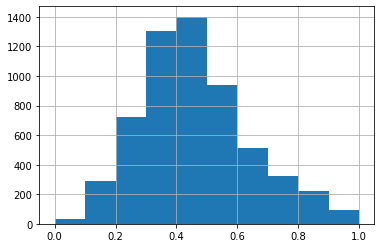

In [12]:
df_ = pd.read_csv("../input/ruddit-jigsaw-dataset/Dataset/ruddit_with_text.csv")
print(df_.shape)

df_ = df_[['txt', 'offensiveness_score']].rename(columns={'txt': 'text',
                                                                'offensiveness_score':'y'})

df_['y'] = (df_['y'] - df_.y.min()) / (df_.y.max() - df_.y.min()) 
df_.y.hist()

# Create 3 versions of data

In [13]:
n_folds = 7

frac_1 = 0.7

for fld in range(n_folds):
    print(f'Fold: {fld}')
    tmp_df = df_.sample(frac=frac_1, random_state = 10*(fld+1))
    tmp_df.to_csv(f'/kaggle/working/df2_fld{fld}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

Fold: 0
(4087, 2)
0.464668    125
0.475910    106
0.375268     94
0.442719     92
0.364561     89
           ... 
0.400964      1
0.889722      1
0.582976      1
0.404711      1
0.761242      1
Name: y, Length: 268, dtype: int64
Fold: 1
(4087, 2)
0.464668    107
0.475910    103
0.408994    102
0.386510     97
0.364561     88
           ... 
0.851713      1
0.859743      1
0.051927      1
0.666488      1
0.594754      1
Name: y, Length: 264, dtype: int64
Fold: 2
(4087, 2)
0.464668    118
0.475910    102
0.386510     94
0.442719     92
0.364561     89
           ... 
0.261777      1
0.238223      1
0.123126      1
0.694861      1
0.309422      1
Name: y, Length: 265, dtype: int64
Fold: 3
(4087, 2)
0.464668    116
0.475910    106
0.386510     93
0.408994     92
0.364561     90
           ... 
0.238223      1
0.561028      1
0.404711      1
0.806210      1
0.184154      1
Name: y, Length: 263, dtype: int64
Fold: 4
(4087, 2)
0.464668    122
0.475910    114
0.386510    100
0.442719     91
0.

In [14]:
del tmp_df, df_; 
gc.collect()

46

## Load Validation and Test data  


In [15]:
# Validation data 

df_val = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")

In [16]:
# Test data

df_sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")


# Create Sklearn Pipeline with 
## TFIDF - Take 'char_wb' as analyzer to capture subwords well
## Ridge - Ridge is a simple regression algorithm that will reduce overfitting 

In [17]:
# NOT USED 
class LengthTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return sparse.csr_matrix([[(len(x)-360)/550] for x in X])
    def get_feature_names(self):
        return ["lngth"]

class LengthUpperTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return sparse.csr_matrix([[sum([1 for y in x if y.isupper()])/len(x)] for x in X])
    def get_feature_names(self):
        return ["lngth_uppercase"]

### Does % of uppercase characters have effect on toxicity


0.06762926181756569 0.1429820536279063
0.10522553566497922 0.20361944552165576


<AxesSubplot:>

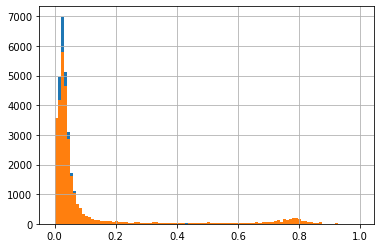

In [18]:

df_val['upper_1'] = np.array(LengthUpperTransformer().transform(df_val['less_toxic']).todense()).reshape(-1,1)
df_val['upper_2'] = np.array(LengthUpperTransformer().transform(df_val['more_toxic']).todense()).reshape(-1,1)

print(df_val['upper_1'].mean(), df_val['upper_1'].std())
print(df_val['upper_2'].mean(), df_val['upper_2'].std())

df_val['upper_1'].hist(bins=100)
df_val['upper_2'].hist(bins=100)

In [19]:
df_val['upper_1'].head(3)

0    0.026316
1    0.017167
2    0.041237
Name: upper_1, dtype: float64

## Train pipeline

- Load folds data
- train pipeline
- Predict on validation data
- Predict on test data

### Toxic data

In [20]:
val_preds_arr1 = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2 = np.zeros((df_val.shape[0], n_folds))
test_preds_arr = np.zeros((df_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv(f'/kaggle/working/df_fld{fld}.csv')
    print(df.shape)

    features = FeatureUnion([
        #('vect1', LengthTransformer()),
        #('vect2', LengthUpperTransformer()),
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),
        #("vect4", TfidfVectorizer(min_df= 5, max_df=0.5, analyzer = 'word', token_pattern=r'(?u)\b\w{8,}\b')),

    ])
    pipeline = Pipeline(
        [
            ("features", features),
            #("clf", RandomForestRegressor(n_estimators = 5, min_sample_leaf=3)),
            ("clf", Ridge()),
            #("clf",LinearRegression())
        ]
    )
    print("\nTrain:")
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity

    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    print("\npredict validation data ")
    val_preds_arr1[:,fld] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2[:,fld] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arr[:,fld] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(28394, 2)

Train:

Total number of features: 146616
[('vect3__uck', 0.53),
 ('vect3__fuc', 0.49),
 ('vect3__ ass', 0.4),
 ('vect3__fuck', 0.38),
 ('vect3__ f ', 0.34),
 ('vect3__ass', 0.32),
 ('vect3__fag', 0.32),
 ('vect3__shit', 0.31),
 ('vect3__ f*', 0.3),
 ('vect3__ fag', 0.29),
 ('vect3__gay', 0.28),
 ('vect3__nig', 0.28),
 ('vect3__nl3', 0.28),
 ('vect3__ fu', 0.27),
 ('vect3__dick', 0.27),
 ('vect3__hit', 0.27),
 ('vect3__nigg', 0.27),
 ('vect3__ck ', 0.26),
 ('vect3__fuk', 0.26),
 ('vect3__ g ', 0.25),
 ('vect3__ nl', 0.25),
 ('vect3__ die', 0.24),
 ('vect3__ gay', 0.24),
 ('vect3__dum', 0.24),
 ('vect3__gga', 0.24),
 ('vect3__kill ', 0.24),
 ('vect3__ ass.', 0.23),
 ('vect3__ u ', 0.23),
 ('vect3__cun', 0.23),
 ('vect3__igg', 0.23)]

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(28394, 2)

Train:

Total number of features: 145297


# Toxic __clean__ data

In [21]:
val_preds_arr1c = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2c = np.zeros((df_val.shape[0], n_folds))
test_preds_arrc = np.zeros((df_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv(f'/kaggle/working/df_clean_fld{fld}.csv')
    print(df.shape)

    features = FeatureUnion([
        #('vect1', LengthTransformer()),
        #('vect2', LengthUpperTransformer()),
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),
        #("vect4", TfidfVectorizer(min_df= 5, max_df=0.5, analyzer = 'word', token_pattern=r'(?u)\b\w{8,}\b')),

    ])
    pipeline = Pipeline(
        [
            ("features", features),
            #("clf", RandomForestRegressor(n_estimators = 5, min_sample_leaf=3)),
            ("clf", Ridge()),
            #("clf",LinearRegression())
        ]
    )
    print("\nTrain:")
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity

    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    print("\npredict validation data ")
    val_preds_arr1c[:,fld] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2c[:,fld] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arrc[:,fld] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(28394, 2)

Train:

Total number of features: 146616
[('vect3__uck', 0.53),
 ('vect3__fuc', 0.49),
 ('vect3__ ass', 0.4),
 ('vect3__fuck', 0.38),
 ('vect3__ f ', 0.34),
 ('vect3__ass', 0.32),
 ('vect3__fag', 0.32),
 ('vect3__shit', 0.31),
 ('vect3__ f*', 0.3),
 ('vect3__ fag', 0.29),
 ('vect3__gay', 0.28),
 ('vect3__nig', 0.28),
 ('vect3__nl3', 0.28),
 ('vect3__ fu', 0.27),
 ('vect3__dick', 0.27),
 ('vect3__hit', 0.27),
 ('vect3__nigg', 0.27),
 ('vect3__ck ', 0.26),
 ('vect3__fuk', 0.26),
 ('vect3__ g ', 0.25),
 ('vect3__ nl', 0.25),
 ('vect3__ die', 0.24),
 ('vect3__ gay', 0.24),
 ('vect3__dum', 0.24),
 ('vect3__gga', 0.24),
 ('vect3__kill ', 0.24),
 ('vect3__ ass.', 0.23),
 ('vect3__ u ', 0.23),
 ('vect3__cun', 0.23),
 ('vect3__igg', 0.23)]

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(28394, 2)

Train:

Total number of features: 145297


## Ruddit data pipeline

In [22]:
val_preds_arr1_ = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2_ = np.zeros((df_val.shape[0], n_folds))
test_preds_arr_ = np.zeros((df_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv(f'/kaggle/working/df2_fld{fld}.csv')
    print(df.shape)

    features = FeatureUnion([
        #('vect1', LengthTransformer()),
        #('vect2', LengthUpperTransformer()),
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),
        #("vect4", TfidfVectorizer(min_df= 5, max_df=0.5, analyzer = 'word', token_pattern=r'(?u)\b\w{8,}\b')),

    ])
    pipeline = Pipeline(
        [
            ("features", features),
            #("clf", RandomForestRegressor(n_estimators = 5, min_sample_leaf=3)),
            ("clf", Ridge()),
            #("clf",LinearRegression())
        ]
    )
    print("\nTrain:")
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity

    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    print("\npredict validation data ")
    val_preds_arr1_[:,fld] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2_[:,fld] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arr_[:,fld] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(4087, 2)

Train:

Total number of features: 31907
[('vect3__fuc', 0.59),
 ('vect3__fuck', 0.59),
 ('vect3__uck', 0.55),
 ('vect3__ fuc', 0.52),
 ('vect3__ fuck', 0.52),
 ('vect3__ fu', 0.42),
 ('vect3__shit', 0.4),
 ('vect3__hit', 0.37),
 ('vect3__ shit', 0.36),
 ('vect3__fuck ', 0.34),
 ('vect3__ck ', 0.32),
 ('vect3__uck ', 0.31),
 ('vect3__shi', 0.29),
 ('vect3__ shi', 0.28),
 ('vect3__ ass ', 0.27),
 ('vect3__sex', 0.26),
 ('vect3__ ass', 0.25),
 ('vect3__ dick', 0.25),
 ('vect3__dick', 0.25),
 ('vect3__ dic', 0.24),
 ('vect3__ sex', 0.24),
 ('vect3__ sh', 0.23),
 ('vect3__shit ', 0.23),
 ('vect3__ass', 0.21),
 ('vect3__ di', 0.19),
 ('vect3__ du', 0.18),
 ('vect3__!!!', 0.18),
 ('vect3__dic', 0.18),
 ('vect3__ex ', 0.18),
 ('vect3__hit ', 0.18)]

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(4087, 2)

Train:

Total number of features:

In [23]:
del df, pipeline, feature_wts
gc.collect()

431

In [24]:

print(" Toxic CLEAN data ")
p5 = val_preds_arr1c.mean(axis=1)
p6 = val_preds_arr2c.mean(axis=1)

print(f'Validation Accuracy is { np.round((p5 < p6).mean() * 100,2)}')

 Toxic CLEAN data 
Validation Accuracy is 68.46


In [25]:

print(" Toxic CLEAN data new ")
p5 = val_preds_arr1c.mean(axis=1)
p6 = val_preds_arr2c.mean(axis=1)

print(f'Validation Accuracy is { np.round((p5 < p6).mean() * 100,2)}')

 Toxic CLEAN data new 
Validation Accuracy is 68.46


# Validate the pipeline 

In [26]:
print(" Toxic data ")
p1 = val_preds_arr1.mean(axis=1)
p2 = val_preds_arr2.mean(axis=1)

print(f'Validation Accuracy is { np.round((p1 < p2).mean() * 100,2)}')

print(" Ruddit data ")
p3 = val_preds_arr1_.mean(axis=1)
p4 = val_preds_arr2_.mean(axis=1)

print(f'Validation Accuracy is { np.round((p3 < p4).mean() * 100,2)}')

print(" Toxic CLEAN data ")
p5 = val_preds_arr1c.mean(axis=1)
p6 = val_preds_arr2c.mean(axis=1)

print(f'Validation Accuracy is { np.round((p5 < p6).mean() * 100,2)}')


 Toxic data 
Validation Accuracy is 68.46
 Ruddit data 
Validation Accuracy is 62.56
 Toxic CLEAN data 
Validation Accuracy is 68.46


In [27]:
print("Find right weight")

wts_acc = []
for i in range(30,70,1):
    for j in range(0,20,1):
        w1 = i/100
        w2 = (100 - i - j)/100
        w3 = (1 - w1 - w2 )
        p1_wt = w1*p1 + w2*p3 + w3*p5
        p2_wt = w1*p2 + w2*p4 + w3*p6
        wts_acc.append( (w1,w2,w3, 
                         np.round((p1_wt < p2_wt).mean() * 100,2))
                      )
sorted(wts_acc, key=lambda x:x[3], reverse=True)[:5]

Find right weight


[(0.56, 0.25, 0.18999999999999995, 69.0),
 (0.57, 0.25, 0.18000000000000005, 69.0),
 (0.58, 0.25, 0.17000000000000004, 69.0),
 (0.59, 0.25, 0.16000000000000003, 69.0),
 (0.6, 0.25, 0.15000000000000002, 69.0)]

In [28]:
w1,w2,w3,_ = sorted(wts_acc, key=lambda x:x[2], reverse=True)[0]
#print(best_wts)

p1_wt = w1*p1 + w2*p3 + w3*p5
p2_wt = w1*p2 + w2*p4 + w3*p6


## Analyze bad predictions 
### Incorrect predictions with similar scores
### Incorrect predictions with different scores

In [29]:
df_val['p1'] = p1_wt
df_val['p2'] = p2_wt
df_val['diff'] = np.abs(p2_wt - p1_wt)

df_val['correct'] = (p1_wt < p2_wt).astype('int')


In [30]:

### Incorrect predictions with similar scores

df_val[df_val.correct == 0].sort_values('diff', ascending=True).head(20)

,worker,less_toxic,more_toxic,upper_1,upper_2,p1,p2,diff,correct
4146,209,"AN/Incidents comment \n\nHello, I ran into your comment on the Incidents noticeboard under unblocking of Giovanni33 and saw your post about how sockpuppet users can fool checkuser. I figured that if you are indeed correct about the possible methods then maybe you should delete that part of comm...","""\n\nShame on me\nYesterday, I was enjoying a bottle of Louis Roederer, with friends, when I idiotically added """"some watch matched"""" at the Death of Hitler article. After they left, I got onto my watchlist and there you go. Should have taken a nap. Sorry, my apologies. Thanks for straightening ...",0.023136,0.042763,0.234709,0.234697,0.000012,0
4145,387,"AN/Incidents comment \n\nHello, I ran into your comment on the Incidents noticeboard under unblocking of Giovanni33 and saw your post about how sockpuppet users can fool checkuser. I figured that if you are indeed correct about the possible methods then maybe you should delete that part of comm...","""\n\nShame on me\nYesterday, I was enjoying a bottle of Louis Roederer, with friends, when I idiotically added """"some watch matched"""" at the Death of Hitler article. After they left, I got onto my watchlist and there you go. Should have taken a nap. Sorry, my apologies. Thanks for straightening ...",0.023136,0.042763,0.234709,0.234697,0.000012,0
4147,59,"AN/Incidents comment \n\nHello, I ran into your comment on the Incidents noticeboard under unblocking of Giovanni33 and saw your post about how sockpuppet users can fool checkuser. I figured that if you are indeed correct about the possible methods then maybe you should delete that part of comm...","""\n\nShame on me\nYesterday, I was enjoying a bottle of Louis Roederer, with friends, when I idiotically added """"some watch matched"""" at the Death of Hitler article. After they left, I got onto my watchlist and there you go. Should have taken a nap. Sorry, my apologies. Thanks for straightening ...",0.023136,0.042763,0.234709,0.234697,0.000012,0
17040,141,I will follow the guidelines as they are. But would surely hope that you do some checking in other publications than the English one as well. And be frank. I at least use my own name and not a nickname like yourself. I think that counts for something. At least for getting my butt kicked under my...,You did it again ! Why did you change the article and put back lots of really poor grammar? Do you even understand that there are grammar mistakes?\n\njoin in the murdering = mistake\n\ncountered the Japanese assassins = mistake\n\nthe assassins trespass = mistake\n\nJapanese assassins burned an...,0.028571,0.015083,0.265419,0.265407,0.000012,0
17042,407,I will follow the guidelines as they are. But would surely hope that you do some checking in other publications than the English one as well. And be frank. I at least use my own name and not a nickname like yourself. I think that counts for something. At least for getting my butt kicked under my...,You did it again ! Why did you change the article and put back lots of really poor grammar? Do you even understand that there are grammar mistakes?\n\njoin in the murdering = mistake\n\ncountered the Japanese assassins = mistake\n\nthe assassins trespass = mistake\n\nJapanese assassins burned an...,0.028571,0.015083,0.265419,0.265407,0.000012,0
17041,214,I will follow the guidelines as they are. But would surely hope that you do some checking in other publications than the English one as well. And be frank. I at least use my own name and not a nickname like yourself. I think that counts for something. At least for getting my butt kicked under my...,You did it again ! Why did you change the article and put back lots of really poor grammar? Do you even understand that there are grammar mistakes?\n\njoin in the murdering = mistake\n\ncountered the Japanese assassins = mistake\n\nthe assassins trespass = mistake\n\nJapanese assassins burned an...,0.028571,0.015083,0.

#### Some of these just look incorrectly tagged 


In [31]:
### Incorrect predictions with dis-similar scores


df_val[df_val.correct == 0].sort_values('diff', ascending=False).head(20)

,worker,less_toxic,more_toxic,upper_1,upper_2,p1,p2,diff,correct
25062,246,CaliforniaAliBaba is a Bitch\nGo fuck yourself you bitch ass motherfucker. Don't you ever in your fucking life threatening me you fucking piece of shit you. You don't know me I will fucking kill your ass you punk pussy bitch. tell your mama to my black dick.,I've heard a snippet on their myspace page but I'm afraid I haven't given them much though musically as of yet. Perhaps I will be purchasing one of their albums since I seem to spend about a third of my time on wiki reverting their vandalism.,0.031128,0.024390,1.177612,0.166927,1.010684,0
25754,190,what the hell man? why did you delete my page (savannah hoard) screw you dude\n\ni mean really? if you're not gonna let me have a page then you can go fuck your fat self you 40 year old bitch\n\nyour a total bitch who goes around deleting people's pages you fucking disgust me im gonna kick your ...,""" December 2009 (UTC)\n\n Now there's typical AGW alarmist Watermelon argumentum ad hominem content-vacant suppressive authoritarian WikiNazi rottenness if ever it got posted online. Don't address Monckton's (or Nsaa's) position, but strive (with utter ineffectiveness, I might add) to fault the ...",0.000000,0.039146,0.998328,0.238767,0.759562,0
17192,347,fuck this this is bull shit and it does not even say where shit comes from your fucking ass,Just To Let You Know. You have no life.\nI hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I ...,0.000000,0.091365,1.041609,0.299750,0.741858,0
17193,238,fuck this this is bull shit and it does not even say where shit comes from your fucking ass,Just To Let You Know. You have no life.\nI hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I ...,0.000000,0.091365,1.041609,0.299750,0.741858,0
21059,333,fuck you \n\nyou're an idiot,"What makes you an editor? Why do you use the name of a great dead man? What is your true name, profession, country? \nShamir",0.000000,0.032520,0.972120,0.246182,0.725938,0
9520,102,by the way I AM A FUCKIN FAG FUCK U,"You are a troublemaker, a liar, and a malicious scumbag. If you are looking for trouble, then keep removing links from the article.",0.500000,0.015038,1.007256,0.286255,0.721001,0
20435,504,Fuck you niggerkite. y you deleting so much shit. fuckn loser. dont delete anymore shit. its none of your fucking business,"Bush is the man. \n\nHe had the balls to dispose of Saddam and declare war on Islamic fundamentalism. Regardless of how he went about doing it, or his interest in oil, he did it. He can have the oil, if that's what he wants in return for ridding the world of religious tyranny (hopefully startin...",0.008197,0.027027,0.979069,0.260417,0.718652,0
19411,46,"Ok, what is it \n\nWhy are you such a queer.. you have no power, so why the FUCK are you acting like you do. Grow up you fucking stupid shit head cock eating bastard.. seriously! Get a life, you're just a 17 yo piece of shit.",wow the guy who deleated the stuff on the Habbo NSM is leet. 88!,0.035714,0.062500,0.958274,0.247547,0.710727,0
14595,415,"Hello fuckhead,\nContributions my faggot asshole. You think that because im gay that i dont know shit. you are wrong. you just sit there with nothing to do with your pathetic fucking life that you decide to go and be a complete prick on wikipedia and just delete whatever the fuck u want. Thanks ...",User Syrthiss is a mot*herfuc*ker assh*ole ha ha ha,0.013115,0.039216,1.077614,0.387340,0.690273,0
7788,580,suck my dick \n\nfuck you dirty whore bitch,Stop being such a sissy.,0.000000,0.040000,1.028635,0.353835,0.674799,0


# Predict on test data 

In [32]:
# Predict using pipeline

df_sub['score'] = w1*test_preds_arr.mean(axis=1) + w2*test_preds_arr_.mean(axis=1) + w3*test_preds_arrc.mean(axis=1)

In [33]:
#test_preds_arr

## Correct the rank ordering

In [34]:
# Cases with duplicates scores

df_sub['score'].count() - df_sub['score'].nunique()

14

In [35]:
same_score = df_sub['score'].value_counts().reset_index()[:10]
same_score

,index,score
0,0.708455,3
1,0.552051,2
2,0.328650,2
3,0.324288,2
4,0.286289,2
5,0.358765,2
6,0.340843,2
7,0.167272,2
8,0.368260,2
9,0.296208,2


In [36]:
df_sub[df_sub['score'].isin(same_score['index'].tolist())]

,comment_id,text,score
1832,95080362,"""\n\nPlease do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you. melmac """,0.167272
2842,160935265,"""\n\nPlease do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you. melmac """,0.167272
4757,270227263,YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! ...,0.708455
4758,270227418,YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! ...,0.708455
4759,270227815,YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! ...,0.708455
5752,339478276,"I'm gonna beat you to a bloody pulp then shoot you, execution-style. \n\nI'm gonna beat you to a bloody pulp then shoot you, execution-style.",0.340843
5753,339478966,"I'm gonna beat you to a bloody pulp then shoot you, execution-style. \n\nI'm gonna beat you to a bloody pulp then shoot you, execution-style.",0.340843
5832,345043812,JIMBO SAID I COULD EDIT HIS PAGE. YOU ARE A MORON.,0.368260
5833,345043888,JIMBO SAID I COULD EDIT HIS PAGE. YOU ARE A MORON.,0.368260
5852,346641598,WE ARE GOING TO MAKE SURE YOU ARE EXPOSED!! DROP YOUR RELATIONS WITH ANTI AMERICAN HATE GROUPS 'WE ARE GOING TO MAKE SURE YOU ARE EXPOSED!! DROP YOUR RELATIONS WITH ANTI AMERICAN HATE GROUPS,0.286289


# Bert Ensemble

In [38]:
%%time

import os
import gc
import cv2
import copy
import time
import random

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For Transformer Models
from transformers import AutoTokenizer, AutoModel

# Utils
from tqdm import tqdm

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

CONFIG = dict(
    seed = 42,
    model_name = '../input/roberta-base',
    test_batch_size = 64,
    max_length = 128,
    num_classes = 1,
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
)

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])

MODEL_PATHS = [
    '../input/k/saurabhbagchi/pytorch-w-b-jigsaw-starter/Loss-Fold-0.bin',
    '../input/k/saurabhbagchi/pytorch-w-b-jigsaw-starter/Loss-Fold-1.bin',
    '../input/k/saurabhbagchi/pytorch-w-b-jigsaw-starter/Loss-Fold-2.bin',
    '../input/k/saurabhbagchi/pytorch-w-b-jigsaw-starter/Loss-Fold-3.bin',
    '../input/k/saurabhbagchi/pytorch-w-b-jigsaw-starter/Loss-Fold-4.bin'
]

def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    
class JigsawDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len,
                        padding='max_length'
                    )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']        
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long)
        }    

    
class JigsawModel(nn.Module):
    def __init__(self, model_name):
        super(JigsawModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.drop(out[1])
        outputs = self.fc(out)
        return outputs
    
@torch.no_grad()
def valid_fn(model, dataloader, device):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask)
        PREDS.append(outputs.view(-1).cpu().detach().numpy()) 
    
    PREDS = np.concatenate(PREDS)
    gc.collect()
    
    return PREDS


def inference(model_paths, dataloader, device):
    final_preds = []
    for i, path in enumerate(model_paths):
        model = JigsawModel(CONFIG['model_name'])
        model.to(CONFIG['device'])
        model.load_state_dict(torch.load(path))
        
        print(f"Getting predictions for model {i+1}")
        preds = valid_fn(model, dataloader, device)
        final_preds.append(preds)
    
    final_preds = np.array(final_preds)
    final_preds = np.mean(final_preds, axis=0)
    return final_preds


set_seed(CONFIG['seed'])
df = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")
df.head()

test_dataset = JigsawDataset(df, CONFIG['tokenizer'], max_length=CONFIG['max_length'])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['test_batch_size'],
                         num_workers=2, shuffle=False, pin_memory=True)

preds1 = inference(MODEL_PATHS, test_loader, CONFIG['device'])

Getting predictions for model 1


100%|██████████| 118/118 [00:31<00:00,  3.79it/s]


Getting predictions for model 2


100%|██████████| 118/118 [00:30<00:00,  3.91it/s]


Getting predictions for model 3


100%|██████████| 118/118 [00:30<00:00,  3.90it/s]


Getting predictions for model 4


100%|██████████| 118/118 [00:30<00:00,  3.91it/s]


Getting predictions for model 5


100%|██████████| 118/118 [00:30<00:00,  3.89it/s]


CPU times: user 2min 43s, sys: 6.16 s, total: 2min 49s
Wall time: 3min 33s


In [39]:
preds = (preds1-preds1.min())/(preds1.max()-preds1.min())

In [40]:
df_sub['score'] = df_sub['score']*0.85+preds*0.15 #0.82->0.85->0.90, 0.17->0.15->0.10

In [41]:
df_sub[['comment_id', 'score']].to_csv("submission.csv", index=False)